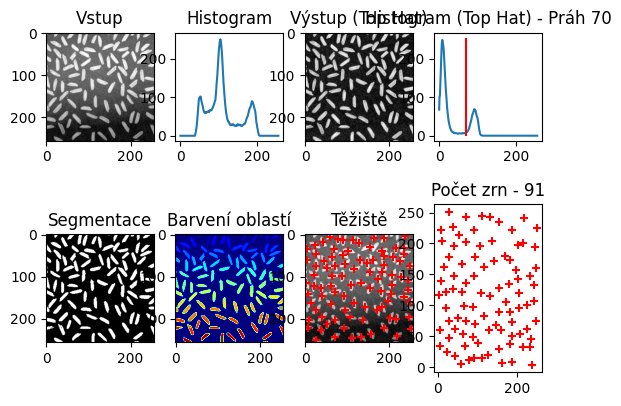

In [3]:
from pathlib import Path
from collections import deque

import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_histogram(image, smoothing):
    """Funkce pro získání histogramu

    Args:
        image: Zdrojový obrázek
        smoothing: Síla vyhlazování výsledného histogramu

    Returns:
        Vyhlazený histogram
    """
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    normalized = histogram / np.max(histogram) * 255

    flattened = np.ndarray.flatten(normalized)
    smoothed = np.convolve(flattened, np.ones(smoothing)/smoothing, mode='same')

    return smoothed

def bfs_coloring(image):
    """Funkce pro barvení oblastí pomocí prohledávání do šířky

    Args:
        image: Binární obrázek k barvení

    Returns:
        Matice s očíslovanými oblastmi
    """
    rows, cols = image.shape
    visited = np.zeros_like(image).astype("bool")
    colors = np.zeros_like(image).astype("uint8")

    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def is_valid(x, y):
        return 0 <= x < rows and 0 <= y < cols

    def bfs(x, y, color):
        queue = deque([(x, y)])
        visited[x][y] = True
        colors[x][y] = color

        # Zkoumáme všechny okolní body, dokud je v rámci obrázku, nebyli jsme na něm a je vysegmentovaný jako 1
        while queue:
            current_x, current_y = queue.popleft()

            for dx, dy in directions:
                new_x, new_y = current_x + dx, current_y + dy
                if is_valid(new_x, new_y) and not visited[new_x][new_y] and image[new_x][new_y] == 1:
                    queue.append((new_x, new_y))
                    visited[new_x][new_y] = True
                    colors[new_x][new_y] = color

    color_count = 0
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j] and image[i][j] == 1:
                color_count += 1
                bfs(i, j, color_count)

    return colors

def get_centers_of_mass(image):
    """Funkce pro výpočet těžiště v segmentovaných oblastech

    Args:
        image: Matice s očíslovanými oblastmi. Pozadí je označeno číslem 0.

    Returns:
        Pole bodů těžišť.
    """
    points = []

    for i in range(1, np.max(image) + 1):
        copy = np.zeros_like(image)
        copy[image == i] = 1

        # Pokud není "celé zrno", tak nepočítáme
        if np.sum(copy) < 90:
            continue

        moments = cv2.moments(copy, True)
        points.append([int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"])])

    return points

image = cv2.imread(Path("./cv09_rice.bmp").as_posix())
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_hist = get_histogram(image, 3)

tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, np.ones((3, 3), np.uint8), iterations=15)
tophat_hist = get_histogram(tophat, 3)

threshold = 70
segmentation = np.zeros_like(tophat)
segmentation[tophat < threshold] = 0
segmentation[tophat >= threshold] = 1

regions = bfs_coloring(segmentation)
points = get_centers_of_mass(regions)

rows = 2
cols = 4

plt.subplot(rows, cols, 1)
plt.imshow(image, cmap="gray")
plt.title("Vstup")

plt.subplot(rows, cols, 2)
plt.plot(image_hist)
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.axis('square')
plt.title("Histogram")

plt.subplot(rows, cols, 3)
plt.imshow(tophat, cmap="gray")
plt.title("Výstup (Top Hat)")

plt.subplot(rows, cols, 4)
plt.plot(tophat_hist)
plt.xlim(0, 255)
plt.ylim(0, 255)
plt.vlines([threshold], 0, 255, "red")
plt.axis('square')
plt.title(f"Histogram (Top Hat) - Práh {threshold}")

plt.subplot(rows, cols, 5)
plt.imshow(segmentation, cmap="gray")
plt.title("Segmentace")

plt.subplot(rows, cols, 6)
plt.imshow(regions / np.max(regions) * 255, cmap="jet")
plt.title("Barvení oblastí")

plt.subplot(rows, cols, 7)
plt.imshow(image, cmap="gray")
plt.scatter(*zip(*points), marker="+", color="red")
plt.title("Těžiště")

plt.subplot(rows, cols, 8)
plt.scatter(*zip(*points), marker="+", color="red")
plt.title(f"Počet zrn - {len(points)}")

plt.show()

Total Grains: 91


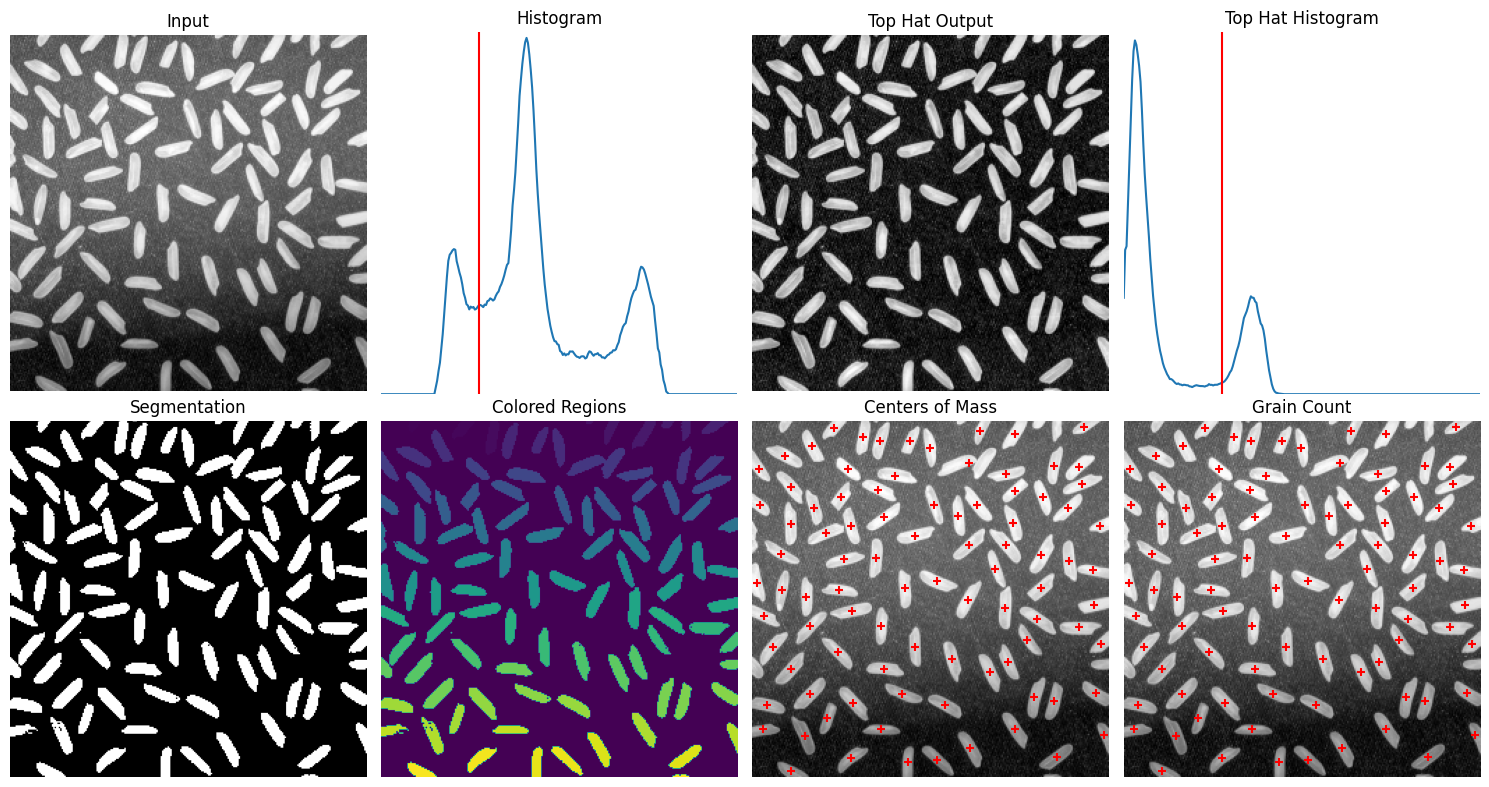

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import deque

class RiceGrainAnalyzer:
    def __init__(self, image_path):
        self.image_path = image_path
        self.load_image()

    def load_image(self):
        self.image = cv2.imread(Path(self.image_path).as_posix(), cv2.IMREAD_GRAYSCALE)
        if self.image is None:
            raise FileNotFoundError(f"No image found at {self.image_path}")

    def compute_smooth_histogram(self, image, smoothing=3):
        histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
        normalized = histogram / np.max(histogram) * 255
        smoothed = np.convolve(np.ndarray.flatten(normalized), np.ones(smoothing)/smoothing, mode='same')
        return smoothed

    def apply_tophat_transform(self, kernel_size=3, iterations=15):
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        self.tophat = cv2.morphologyEx(self.image, cv2.MORPH_TOPHAT, kernel, iterations=iterations)
        return self.tophat

    def threshold_image(self, threshold=70):
        self.segmentation = (self.tophat >= threshold).astype(np.uint8)
        return self.segmentation

    def label_image_regions(self, image):
        rows, cols = image.shape
        visited = np.zeros_like(image).astype("bool")
        labels = np.zeros_like(image).astype("uint8")
        directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        
        def is_within_bounds(x, y):
            """Check if the coordinates are within the image bounds."""
            return 0 <= x < rows and 0 <= y < cols

        def bfs(start_x, start_y, label):
            """Perform BFS from the start point and label all connected pixels."""
            queue = deque([(start_x, start_y)])
            visited[start_x][start_y] = True
            labels[start_x][start_y] = label
    
            while queue:
                x, y = queue.popleft()
                for dx, dy in directions:
                    nx, ny = x + dx, y + dy
                    if is_within_bounds(nx, ny) and not visited[nx][ny] and image[nx][ny] == 1:
                        queue.append((nx, ny))
                        visited[nx][ny] = True
                        labels[nx][ny] = label
        color_count = 0
        for i in range(rows):
            for j in range(cols):
                if not visited[i][j] and image[i][j] == 1:
                    color_count += 1
                    bfs(i, j, color_count)
        return labels

    def get_region_values(self, image):
        values = []
        for i in range(1, np.max(image) + 1):
            copy = np.zeros_like(image)
            copy[image == i] = 1
            
            if np.sum(copy) < 90:
                continue
            moments = cv2.moments(copy, True)
            values.append([int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"])])
        return values

    def analyze(self):
        self.apply_tophat_transform()
        self.threshold_image()
        self.regions = self.label_image_regions(self.segmentation)
        self.points = self.get_region_values(self.regions)
        self.display_results()

    def display_results(self):
        plt.figure(figsize=(15, 8))
        images = [self.image, self.compute_smooth_histogram(self.image), self.tophat,
                  self.compute_smooth_histogram(self.tophat), self.segmentation,
                  self.regions / np.max(self.regions) * 255, self.image, self.image]
        titles = ["Input", "Histogram", "Top Hat Output", "Top Hat Histogram",
                  "Segmentation", "Colored Regions", "Centers of Mass", "Grain Count"]

        for i, (img, title) in enumerate(zip(images, titles), 1):
            ax = plt.subplot(2, 4, i)
            if "Histogram" in title:
                ax.plot(img)
                ax.set_xlim(0, 255)
                ax.set_ylim(0, 255)
                ax.vlines([70], 0, 255, "red")  # Example threshold
            elif "Centers" in title:
                ax.imshow(self.image, cmap='gray')
                ax.scatter(*zip(*self.points), marker="+", color="red")
            elif "Grain Count" in title:
                # print total grain count
                print(f"Total Grains: {len(self.points)}")
                ax.imshow(self.image, cmap='gray')
                ax.scatter(*zip(*self.points), marker="+", color="red")
                ax.set_title(f"Total Grains: {len(self.points)}")
            else:
                ax.imshow(img, cmap='gray' if i != 6 else None)
            ax.set_title(title)
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Usage
analyzer = RiceGrainAnalyzer("./cv09_rice.bmp")
analyzer.analyze()
